### Setup Environment:

In [1]:
import os
import pandas as pd

from src.classifiers import preprocess_data, process_labels,split_data

from src.classifiers import VQADataset
from torch.utils.data import DataLoader

from src.classifiers import train_early_fusion, train_late_fusion

In [2]:
PATH = 'Embeddings/fakeddit_subset/'
COLUMN = 'embeddings'

In [3]:
text_path, images_path = os.listdir(PATH)

## Get data

### Text

In [4]:
text = pd.read_csv(os.path.join(PATH, text_path))
text

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label,split,embeddings
0,michaelconfoy,loose talk got there first keep it under your ...,1.429942e+09,i.imgur.com,True,33snxf.jpg,https://external-preview.redd.it/TfwZkzBSsqgq0...,NaN,6.0,70,propagandaposters,"""Loose talk got there first! Keep it under you...",0.98,0,1,5,train,"[-0.970077633857727, 2.124223470687866, 2.7805..."
1,SaltMineForeman,this tree at my campsite naturally grew a hear...,1.554421e+09,i.imgur.com,True,b9k2ta.jpg,https://external-preview.redd.it/ulTUeOqBi2y7F...,NaN,2.0,30,mildlyinteresting,This tree at my campsite naturally grew a hear...,0.89,1,0,0,train,"[1.095641016960144, -0.3601342439651489, 0.657..."
2,Shawn_666,fdr addressing the nation,1.522982e+09,i.redd.it,True,8a5wy9.jpg,https://preview.redd.it/fyop34q987q01.png?widt...,NaN,1.0,12,fakehistoryporn,FDR addressing the nation (1932),0.80,0,2,2,train,"[0.9112146496772766, 1.1340166330337524, 0.273..."
3,YOLO2THEMAX,face morph,1.448948e+09,NaN,True,cxiu2qb.jpg,http://i.imgur.com/nLdvOJ5.jpg,3urf4a,NaN,2,psbattle_artwork,Face morph,NaN,0,2,4,train,"[-0.42378801107406616, -2.792628526687622, 3.3..."
4,FarMojo,a japanese kamikaze pilot of the sixth air arm...,1.559169e+09,i.redd.it,True,bul96p.jpg,https://preview.redd.it/3ro69vkv88131.jpg?widt...,NaN,0.0,8,fakehistoryporn,A Japanese kamikaze pilot of the sixth air arm...,0.75,0,2,2,train,"[1.358902931213379, 1.4641591310501099, 3.4799..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68073,Anazron,giant flesheating spiders could soon be moving...,1.472864e+09,grimsbytelegraph.co.uk,True,50whzb.jpg,https://external-preview.redd.it/HEa-SZzApziHx...,NaN,33.0,1587,savedyouaclick,Giant 'flesh-eating' spiders could soon be mov...,0.96,0,2,5,val,"[2.9539952278137207, -1.3575800657272339, 0.64..."
68074,CaptainBubblesMcGee,birdie fjord,1.514092e+09,i.redd.it,True,7lte89.jpg,https://preview.redd.it/pbzko489ys501.jpg?widt...,NaN,1.0,25,fakealbumcovers,Birdie - Fjord,1.00,0,2,1,val,"[-0.03460288047790527, 0.24736623466014862, -1..."
68075,prohitman,spittin hot fire and hairballs,1.456299e+09,NaN,True,d0bptg9.jpg,http://i.imgur.com/aABgTcA.jpg,479m43,NaN,99,psbattle_artwork,Spittin' hot fire... and hairballs,NaN,0,2,4,val,"[2.6579291820526123, -3.2106573581695557, 0.60..."
68076,lux514,supreme court lets full trump travel ban take ...,1.512429e+09,amp.cnn.com,True,7hlb60.jpg,https://external-preview.redd.it/Cqtqrno3dAQVv...,NaN,1.0,3,neutralnews,Supreme Court lets full Trump travel ban take ...,1.00,1,0,0,val,"[5.113027095794678, -0.20547792315483093, 1.69..."


### Images

In [5]:
images = pd.read_csv(os.path.join(PATH, images_path))
images.head()

,ImageName,0,1,2,3,4,5,6,7,8,...,758,759,760,761,762,763,764,765,766,767
0,33snxf.jpg,0.726765,-2.655783,-0.286309,2.284077,0.620112,-0.513821,-0.157407,-3.692554,-0.593593,...,-1.377306,-1.257390,1.434935,2.678490,-0.813287,-0.247679,3.506964,2.777536,-0.494098,-0.088294
1,b9k2ta.jpg,-0.082641,2.290078,0.258090,1.336584,-1.426128,0.364081,-1.149799,-0.933333,-1.592730,...,3.144165,-3.026214,1.481284,-1.304235,-1.012776,-1.283712,-3.979227,-0.434095,-0.187055,-0.657386
2,8a5wy9.jpg,0.442696,0.138868,1.574348,-2.774248,0.554317,0.693501,3.486655,-1.426318,0.438649,...,-2.711389,-2.506644,0.409061,-2.343080,-4.166866,2.738598,-0.623580,2.672139,-0.628692,0.444250
3,cxiu2qb.jpg,-2.166476,-0.665304,1.496656,0.308857,1.179391,2.050377,0.852495,0.368653,0.921106,...,-1.844824,-1.604552,-2.791408,2.023891,0.001955,1.305366,-2.714160,2.073888,-0.763779,-1.020749
4,bul96p.jpg,0.618357,0.724958,-0.999924,0.586965,0.384611,0.061411,-1.794428,-1.519707,-2.022282,...,2.398909,0.064441,-0.306176,0.836847,2.341117,3.536660,1.313194,1.197324,-0.442961,-0.541935


### Merge and preprocess the datasets

In [6]:
df = preprocess_data(text, images, "id", "ImageName")
df.drop(columns='image_url', inplace=True)
df.head()

,author,clean_title,created_utc,domain,hasImage,linked_submission_id,num_comments,score,subreddit,title,...,image_758,image_759,image_760,image_761,image_762,image_763,image_764,image_765,image_766,image_767
0,michaelconfoy,loose talk got there first keep it under your ...,1.429942e+09,i.imgur.com,True,NaN,6.0,70,propagandaposters,"""Loose talk got there first! Keep it under you...",...,-1.377306,-1.257390,1.434935,2.678490,-0.813287,-0.247679,3.506964,2.777536,-0.494098,-0.088294
1,SaltMineForeman,this tree at my campsite naturally grew a hear...,1.554421e+09,i.imgur.com,True,NaN,2.0,30,mildlyinteresting,This tree at my campsite naturally grew a hear...,...,3.144165,-3.026214,1.481284,-1.304235,-1.012776,-1.283712,-3.979227,-0.434095,-0.187055,-0.657386
2,Shawn_666,fdr addressing the nation,1.522982e+09,i.redd.it,True,NaN,1.0,12,fakehistoryporn,FDR addressing the nation (1932),...,-2.711389,-2.506644,0.409061,-2.343080,-4.166866,2.738598,-0.623580,2.672139,-0.628692,0.444250
3,YOLO2THEMAX,face morph,1.448948e+09,NaN,True,3urf4a,NaN,2,psbattle_artwork,Face morph,...,-1.844824,-1.604552,-2.791408,2.023891,0.001955,1.305366,-2.714160,2.073888,-0.763779,-1.020749
4,FarMojo,a japanese kamikaze pilot of the sixth air arm...,1.559169e+09,i.redd.it,True,NaN,0.0,8,fakehistoryporn,A Japanese kamikaze pilot of the sixth air arm...,...,2.398909,0.064441,-0.306176,0.836847,2.341117,3.536660,1.313194,1.197324,-0.442961,-0.541935


## Data Perparation

In [7]:
# Split the data
train_df, test_df = split_data(df)

# Select features and labels vectors
text_columns = [column for column in df.columns if 'text' in column] #[f'text_{i}']
image_columns = [column for column in df.columns if 'image' in column] #[f'image_{i}']
label_columns = '2_way_label'


# Process and one-hot encode labels for training set
train_labels, mlb, train_columns = process_labels(train_df, col=label_columns)
test_labels = process_labels(test_df, col=label_columns, train_columns=train_columns)


train_dataset = VQADataset(train_df, text_columns, image_columns, label_columns, mlb, train_columns)
test_dataset = VQADataset(test_df, text_columns, image_columns, label_columns, mlb, train_columns)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Train Shape: (56214, 4879)
Test Shape: (5911, 4879)


### Models

In [8]:
text_input_size = len(text_columns)
image_input_size = len(image_columns)
if label_columns == '2_way_label':
    output_size = 1
else:
    output_size = len(pd.unique(train_df[label_columns]))
multilabel = False

Training Early Fusion Model:
Epoch 1/5 - Test Accuracy: 0.9005
Epoch 2/5 - Test Accuracy: 0.9070
Epoch 3/5 - Test Accuracy: 0.9068
Epoch 4/5 - Test Accuracy: 0.9042
Epoch 5/5 - Test Accuracy: 0.9090


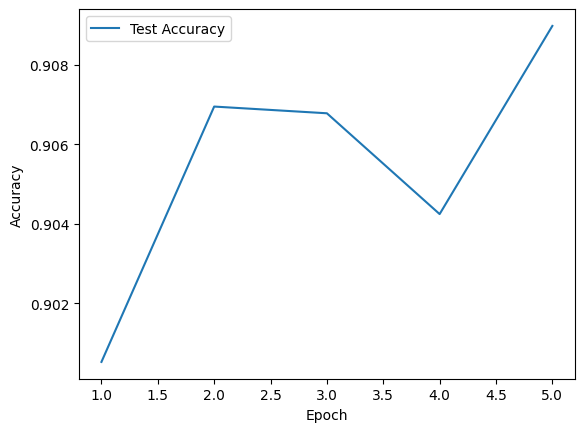

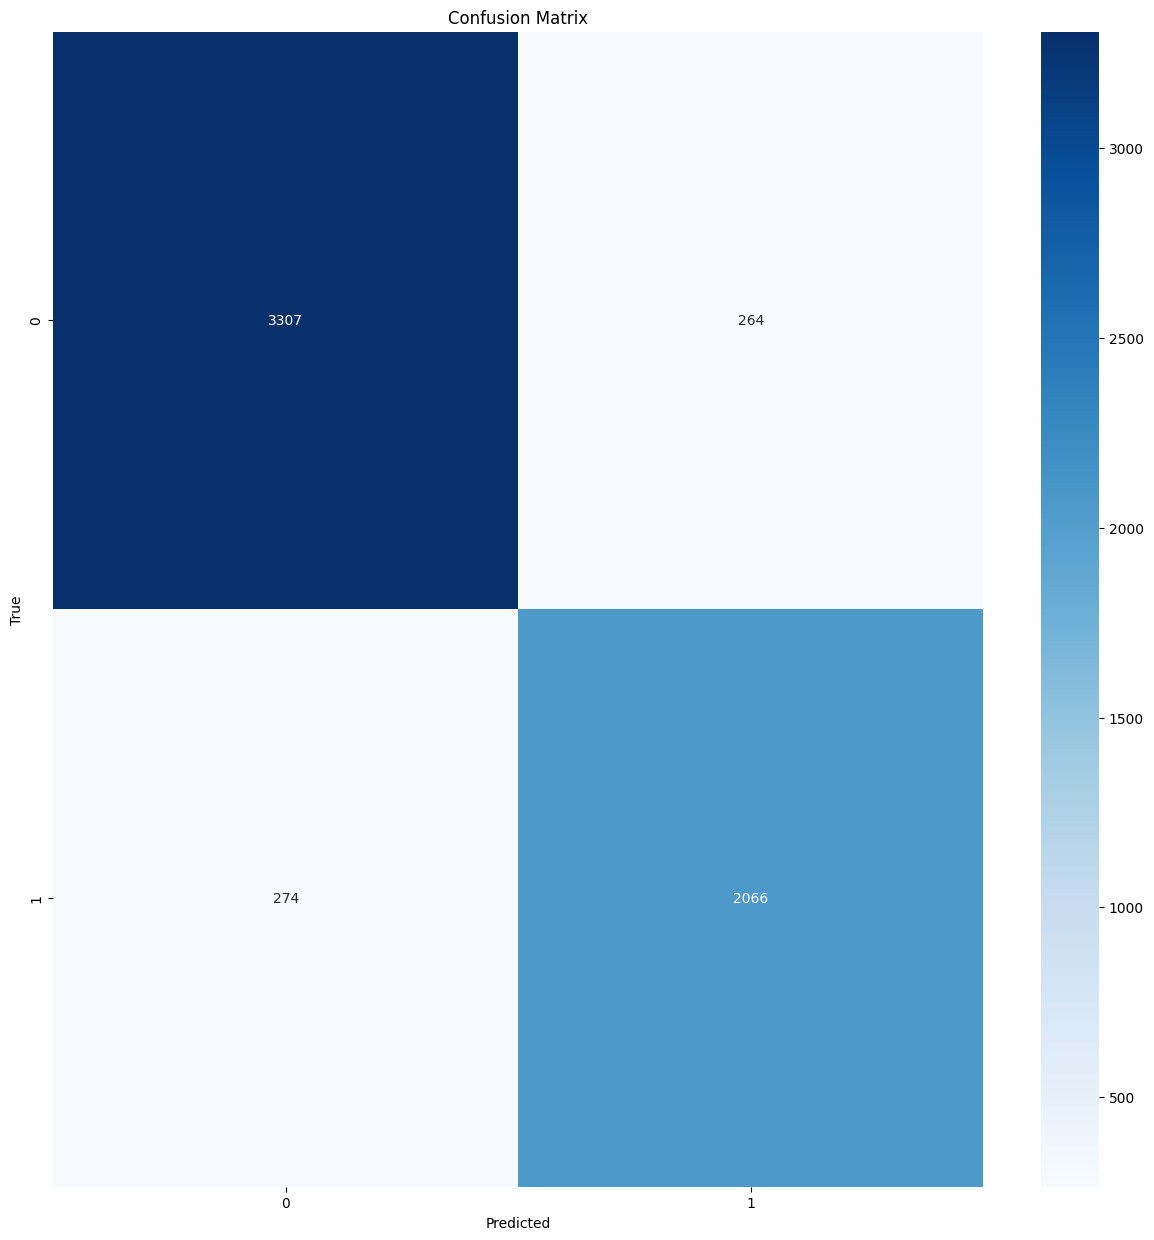

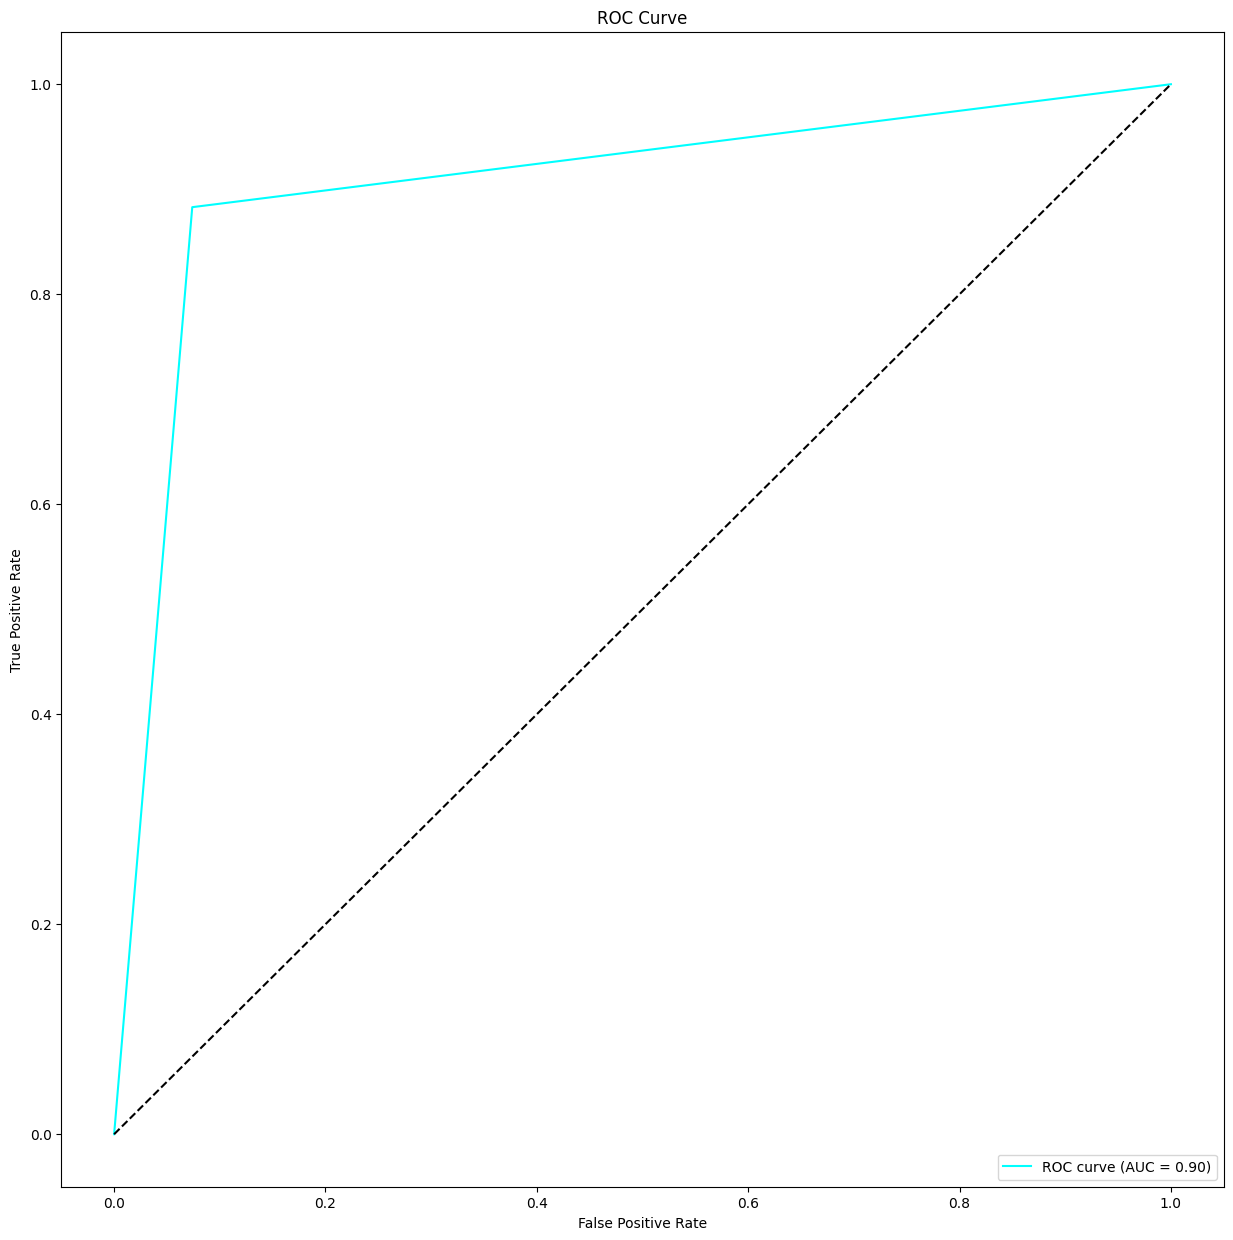

              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92      3571
         1.0       0.89      0.88      0.88      2340

    accuracy                           0.91      5911
   macro avg       0.91      0.90      0.90      5911
weighted avg       0.91      0.91      0.91      5911



In [9]:
# Train early fusion model
print("Training Early Fusion Model:")
train_early_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=5, multilabel=multilabel, report=True)

Training Late Fusion Model:
Epoch 1/5 - Test Accuracy: 0.9044
Epoch 2/5 - Test Accuracy: 0.9085
Epoch 3/5 - Test Accuracy: 0.9098
Epoch 4/5 - Test Accuracy: 0.8965
Epoch 5/5 - Test Accuracy: 0.9054


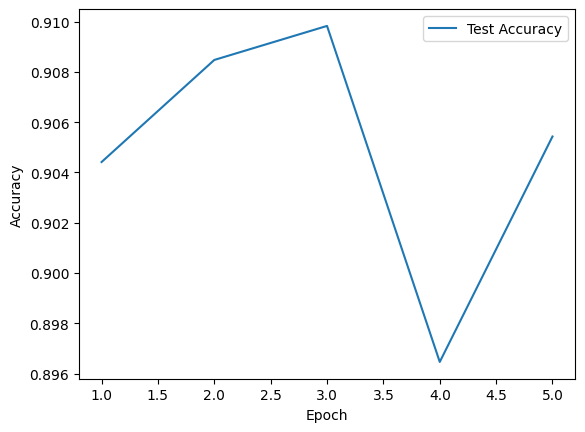

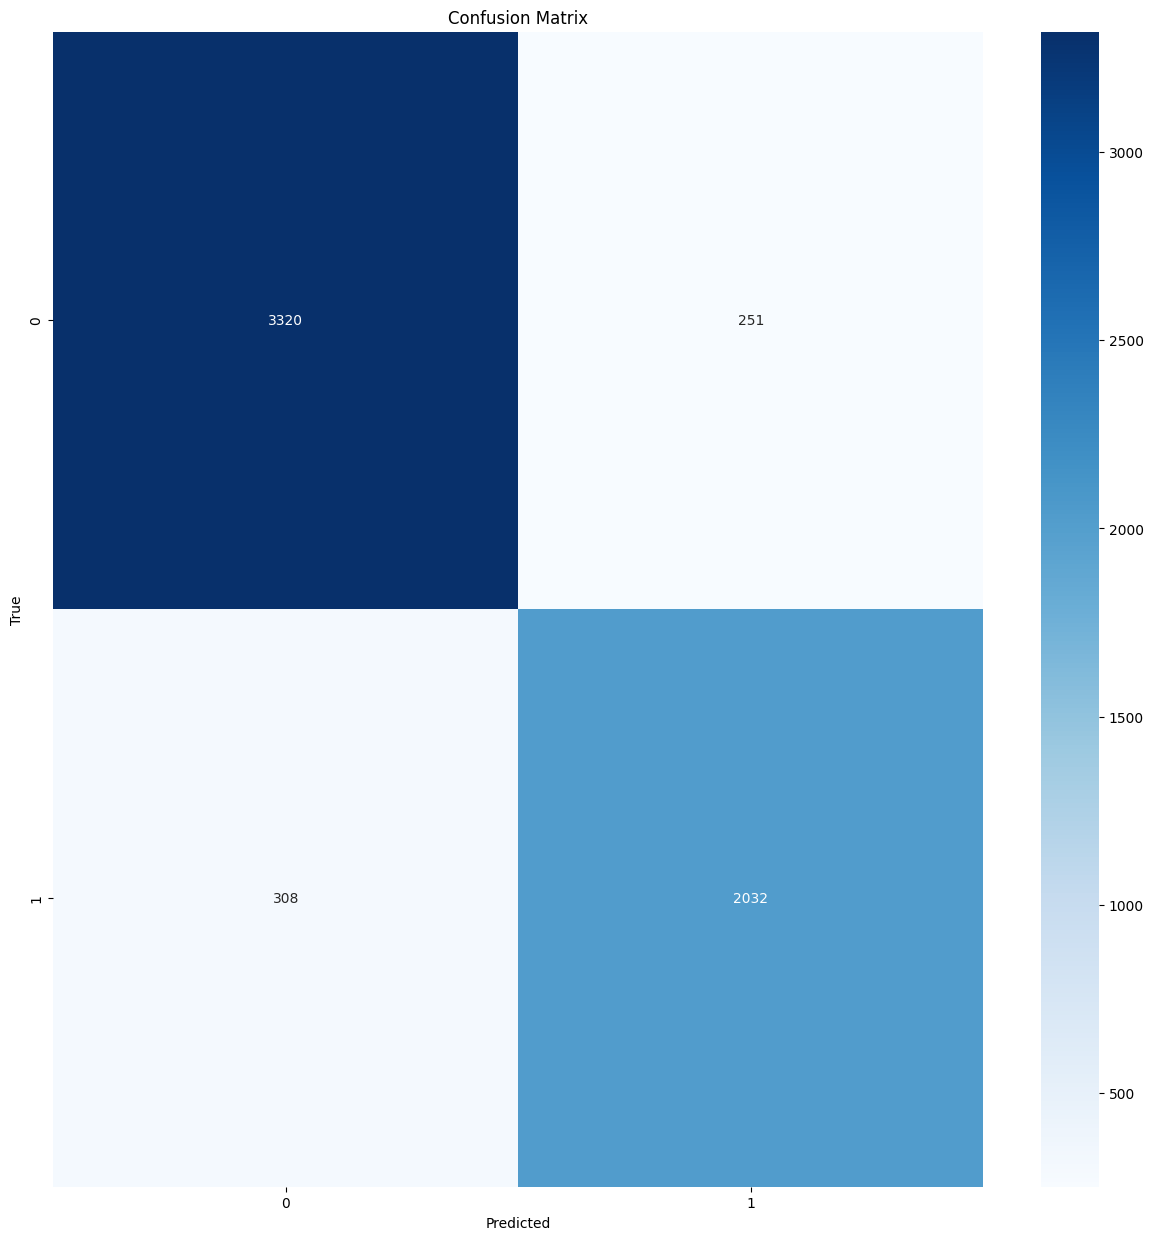

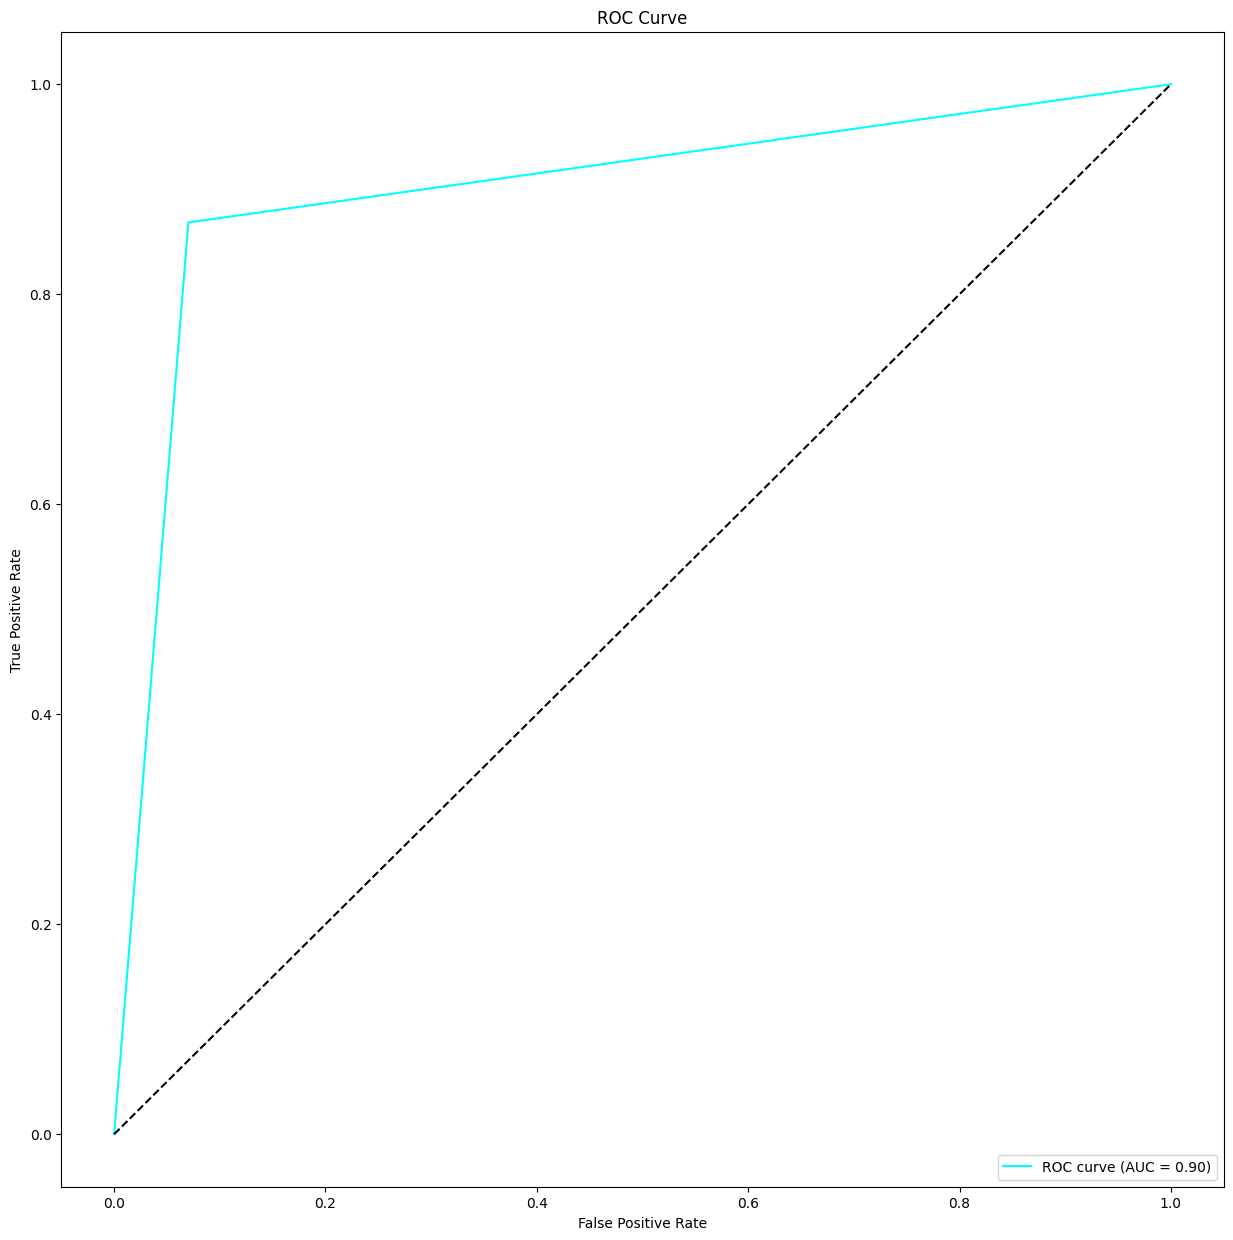

              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92      3571
         1.0       0.89      0.87      0.88      2340

    accuracy                           0.91      5911
   macro avg       0.90      0.90      0.90      5911
weighted avg       0.91      0.91      0.91      5911



In [10]:
# Train late fusion model
print("Training Late Fusion Model:")
train_late_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=5, multilabel=multilabel, report=True)